# Learing the Stein discrepancy directly

In [1]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", False)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("../../../learning_particle_gradients/")
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
import jax.numpy as jnp
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
from jax import random, jit, grad, value_and_grad, vmap

import utils
import stein
import kernels
import distributions
import nets
import models

from jax.experimental import optimizers

key = random.PRNGKey(0)

In [2]:
# # set up exporting
# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
# #     'font.family': 'serif',
# #     'text.usetex': False,
#     'pgf.rcfonts': False,
#     'axes.unicode_minus': False, # avoid unicode error on saving plots with negative numbers (??)
# })

# figure_path = "/home/lauro/documents/msc-thesis/thesis/figures/"
figure_path = "/home/lauro/documents/msc-thesis/paper/latex/figures/"
# save figures by using plt.savefig('title of figure')
# remember that latex textwidth is 5.4in
# so use figsize=[5.4, 4], for example

# Ill-conditioned Gaussian I

In [3]:
%autoreload

In [4]:
d = 50
variances = np.logspace(-5, 0, num=d)
target = distributions.Gaussian(np.zeros(d), variances)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
setup = distributions.Setup(target, proposal)

In [5]:
# optimal SD
@partial(jit, static_argnums=1)
def get_sd(samples, fun):
    """Compute SD(samples, p) given witness function fun"""
    return stein.stein_discrepancy(samples, target.logpdf, fun)


def kl_gradient(x):
    """Optimal witness function."""
    return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x)


print("Computing theoretically optimal Stein discrepancy...")
sds = []
for _ in range(100):
    samples = proposal.sample(100)
    sds.append(get_sd(samples, kl_gradient))

Computing theoretically optimal Stein discrepancy...


In [6]:
# L2
@jit
def squared_error(params, key):
    key, subkey = random.split(key)
    qsamples = proposal.sample(1000, key=subkey)
    f = utils.negative(learner.get_field(
        key, qsamples, params=params))
    return jnp.mean((vmap(f)(qsamples) - vmap(kl_gradient)(qsamples))**2)

In [15]:
# Neural SD
print("Computing neural Stein discrepancy...")
key, subkey = random.split(key)
learner = models.SDLearner(target_dim=d,
                           key=subkey,
                           learning_rate=1e-2,
                           patience=-1)
BATCH_SIZE = 1000


def sample(key):
    return proposal.sample(BATCH_SIZE*2, key).split(2)


key, subkey = random.split(key)
split_particles = sample(subkey)
split_dlogp = [vmap(grad(target.logpdf))(x) for x in split_particles]

Computing neural Stein discrepancy...


In [17]:
sqes = []
for i in tqdm(range(900)):
    key, subkey = random.split(key)
    learner.step(*split_particles,
                 *split_dlogp)
    if i % 20 == 0:
        sqes.append(squared_error(learner.params, subkey))

100%|██████████| 900/900 [01:07<00:00, 13.36it/s]


In [9]:
# Kernelized SD (using Gaussian kernel w/ median heuristic)
@jit
def compute_scaled_ksd(samples):
    kernel = kernels.get_rbf_kernel(kernels.median_heuristic(samples))
    phi = stein.get_phistar(kernel, target.logpdf, samples)
    ksd = stein.stein_discrepancy(samples, target.logpdf, phi)
    return ksd**2 / utils.l2_norm_squared(samples, phi)


print("Computing kernelized Stein discrepancy...")
ksds = []
for _ in tqdm(range(100)):
    samples = proposal.sample(400)
    ksds.append(compute_scaled_ksd(samples))

  0%|          | 0/100 [00:00<?, ?it/s]

Computing kernelized Stein discrepancy...


100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


In [10]:
printsize = [5.4, 4]
showsize = [15, 8]

In [11]:
%matplotlib inline

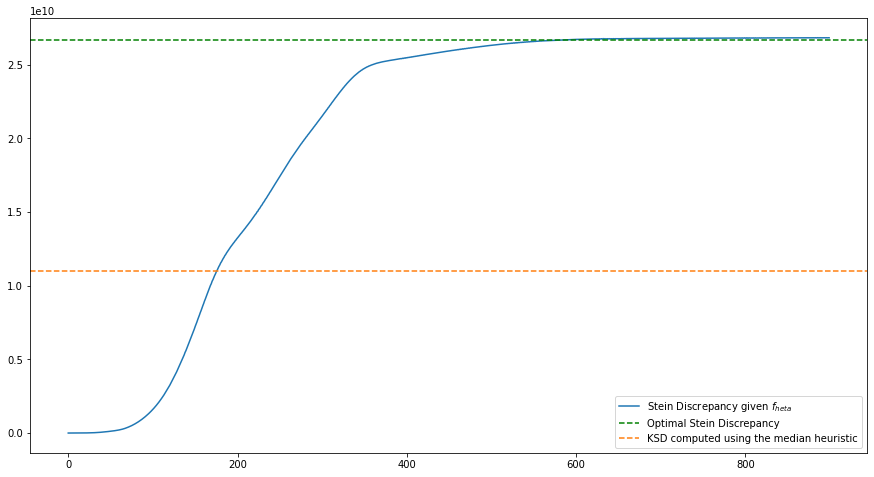

In [18]:
fig, axs = plt.subplots(figsize=showsize) # remember that latex textwidth is 5.4in

plt.plot(learner.rundata["training_sd"], label="Stein Discrepancy given $f_{\theta}$")
# plt.plot(learner.rundata["training_loss"], label="Stein Discrepancy given $f_{\theta}$")
plt.axhline(y=onp.mean(sds), linestyle="--", label="Optimal Stein Discrepancy", color="green")
plt.axhline(y=onp.mean(ksds), linestyle="--", label="KSD computed using the median heuristic", color="tab:orange")
plt.legend()

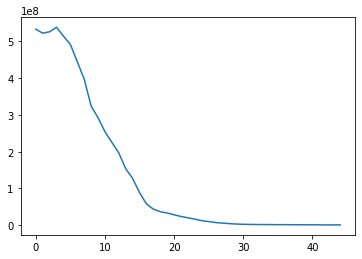

In [19]:
plt.plot(sqes)

In [12]:
figure_path + "sd_maxing.pdf"

'/home/lauro/documents/msc-thesis/paper/latex/figures/sd_maxing.pdf'

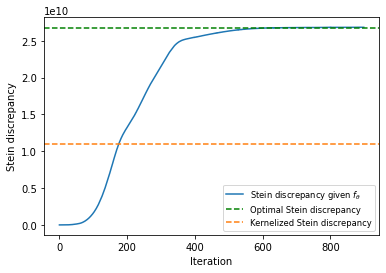

In [20]:
# fig, axs = plt.subplots(figsize=printsize) # remember that latex textwidth is 5.4in
fig, axs = plt.subplots(figsize=[6, 4])

plt.plot(learner.rundata["training_sd"], label="Stein discrepancy given $f_{\\theta}$")
plt.axhline(y=onp.mean(sds), linestyle="--", label="Optimal Stein discrepancy", color="green")
plt.axhline(y=onp.mean(ksds), linestyle="--", label="Kernelized Stein discrepancy", color="tab:orange")


plt.ylabel("Stein discrepancy")
plt.xlabel("Iteration")
plt.legend(fontsize='small')


plt.savefig(figure_path + "sd_maxing.pdf")

In [50]:
plt.rc('font', size=7)
printsize_singlecolumn = [3.6, 3]

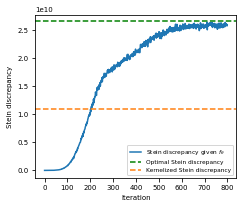

In [51]:
# fig, axs = plt.subplots(figsize=printsize) # remember that latex textwidth is 5.4in
fig, axs = plt.subplots(figsize=printsize_singlecolumn)

plt.plot(learner.rundata["training_sd"], label="Stein discrepancy given $f_{\\theta}$")
plt.axhline(y=onp.mean(sds), linestyle="--", label="Optimal Stein discrepancy", color="green")
plt.axhline(y=onp.mean(ksds), linestyle="--", label="Kernelized Stein discrepancy", color="tab:orange")


plt.ylabel("Stein discrepancy")
plt.xlabel("Iteration")
plt.legend(fontsize='small')


plt.savefig(figure_path + "sd_maxing.pgf")
plt.savefig("sd_maxing.pgf")

# Ill-conditioned Gaussian II, $d = 50$

In [4]:
d = 50
key, subkey = random.split(key)
alpha = 0.5
beta = 1
variances = random.gamma(subkey, alpha, shape=(d,)) / beta

target = distributions.Gaussian(np.zeros(d), variances)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
setup = distributions.Setup(target, proposal)

(array([29.,  3.,  3.,  4.,  3.,  3.,  1.,  2.,  1.,  1.]),
 array([2.2211899e-04, 2.5919217e-01, 5.1816225e-01, 7.7713227e-01,
        1.0361023e+00, 1.2950724e+00, 1.5540425e+00, 1.8130125e+00,
        2.0719826e+00, 2.3309526e+00, 2.5899227e+00], dtype=float32),
 <BarContainer object of 10 artists>)

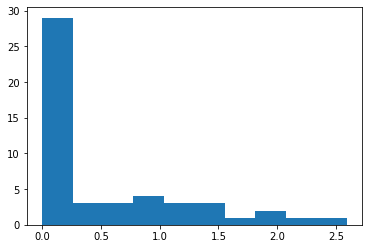

In [20]:
plt.hist(variances)

(array([ 1.,  1.,  0.,  1.,  5.,  8.,  7.,  8.,  8., 11.]),
 array([-8.412297 , -7.475905 , -6.539512 , -5.60312  , -4.666727 ,
        -3.7303345, -2.793942 , -1.8575495, -0.921157 ,  0.0152355,
         0.951628 ], dtype=float32),
 <BarContainer object of 10 artists>)

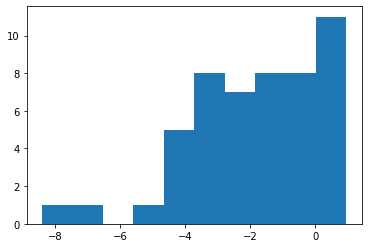

In [21]:
plt.hist(np.log(variances))

In [7]:
def get_ksds(proposal, kernel):
    @jit
    def compute_ksd(samples):
        return stein.ksd_squared_u(samples, target.logpdf, kernel)
    ksds = []
    for _ in tqdm(range(100)):
        samples = proposal.sample(400)
        ksds.append(compute_ksd(samples))
    return ksds

In [8]:
%autoreload

In [9]:
learning_rate = 1e-2
key, subkey = random.split(key)
learner = models.SDLearner(target_dim=d,
                           target_logp=target.logpdf,
                           key=subkey,
                           learning_rate=learning_rate,
                           patience=-1)

batch_size=1000

In [10]:
def sample(key):
    return proposal.sample(batch_size*2, key).split(2)
key, subkey = random.split(key)
learner.train(next_batch=sample, key=subkey, n_steps=1000, progress_bar=True)

100%|██████████| 1000/1000 [02:46<00:00,  5.99it/s]


In [11]:
# compute optimal SD
div = 2*learner.lambda_reg
def kl_gradient(x):
    return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x) / div
sds = []
for _ in range(100):
    samples = proposal.sample(400)
    sds.append(get_sd(samples, kl_gradient))

In [12]:
samples = proposal.sample(1000)
utils.l2_norm_squared(samples, kl_gradient)

DeviceArray(20747494., dtype=float32)

In [14]:
printsize = [5.4, 4]
showsize = [15, 8]

In [17]:
%matplotlib inline

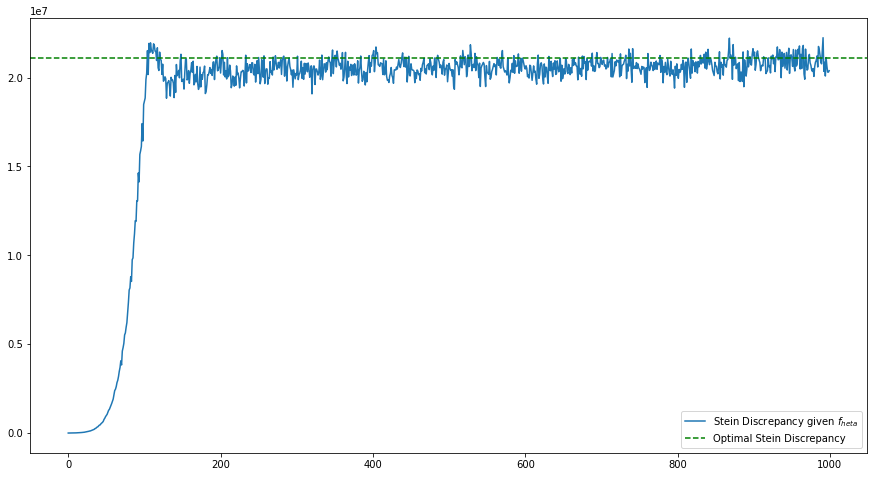

In [18]:
fig, axs = plt.subplots(figsize=showsize) # remember that latex textwidth is 5.4in

plt.plot(learner.rundata["training_sd"], label="Stein Discrepancy given $f_{\theta}$")
plt.axhline(y=onp.mean(sds), linestyle="--", label="Optimal Stein Discrepancy", color="green")
plt.legend()

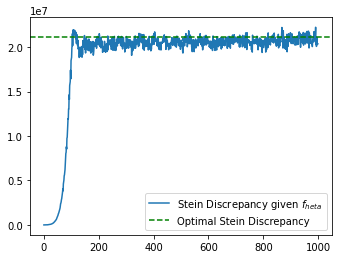

In [19]:
fig, axs = plt.subplots(figsize=printsize) # remember that latex textwidth is 5.4in

plt.plot(learner.rundata["training_sd"], label="Stein Discrepancy given $f_{\theta}$")
plt.axhline(y=onp.mean(sds), linestyle="--", label="Optimal Stein Discrepancy", color="green")
plt.legend()


plt.savefig(figure_path + "sd_maxing.pgf")
plt.savefig("sd_maxing.pgf")

# Ill-conditioned Gaussian, $d = 5000$

In [7]:
d = 1000
key, subkey = random.split(key)
alpha = 0.5
beta = 1
variances = random.gamma(subkey, alpha, shape=(d,)) / beta

target = distributions.Gaussian(np.zeros(d), variances)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
setup = distributions.Setup(target, proposal)

In [8]:
%matplotlib inline

(array([  1.,   0.,   2.,   6.,  12.,  40., 111., 244., 419., 165.]),
 array([-17.02826   , -15.151355  , -13.27445   , -11.397546  ,
         -9.520641  ,  -7.6437373 ,  -5.766833  ,  -3.8899286 ,
         -2.0130243 ,  -0.13611986,   1.7407845 ], dtype=float32),
 <BarContainer object of 10 artists>)

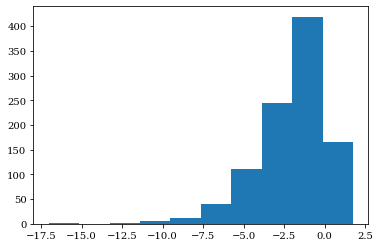

In [9]:
plt.hist(np.log(variances))

In [10]:
learning_rate = 1e-2
key, subkey = random.split(key)
learner = models.SDLearner(target_dim=d,
                           target_logp=target.logpdf,
                           key=subkey,
                           learning_rate=learning_rate,
                           patience=-1,
                           sizes=[256, 256, 1000])

batch_size=10

In [12]:
def sample(key):
    return proposal.sample(batch_size*2, key).split(2)
key, subkey = random.split(key)
learner.train(next_batch=sample, key=subkey, n_steps=2000, progress_bar=True)

100%|██████████| 2000/2000 [14:57<00:00,  2.23it/s]


In [13]:
# compute optimal SD
div = 2*learner.lambda_reg
def kl_gradient(x):
    return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x) / div
sds = []
for _ in range(100):
    samples = proposal.sample(40)
    sds.append(get_sd(samples, kl_gradient))

In [14]:
samples = proposal.sample(40)
utils.l2_norm_squared(samples, kl_gradient)

DeviceArray(6.170584e+14, dtype=float32)

In [15]:
def get_ksds(kernel):
    @jit
    def compute_ksd(samples):
        return stein.ksd_squared_u(samples, target.logpdf, kernel)
    ksds = []
    for _ in tqdm(range(100)):
        samples = proposal.sample(10)
        ksds.append(compute_ksd(samples))
    return ksds

In [16]:
ksds = get_ksds(kernels.get_rbf_kernel(1.))

100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


In [17]:
samples = proposal.sample(100)
median_h = kernels.median_heuristic(samples)
median_heuristic_ksds = get_ksds(kernels.get_rbf_kernel(median_h))

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


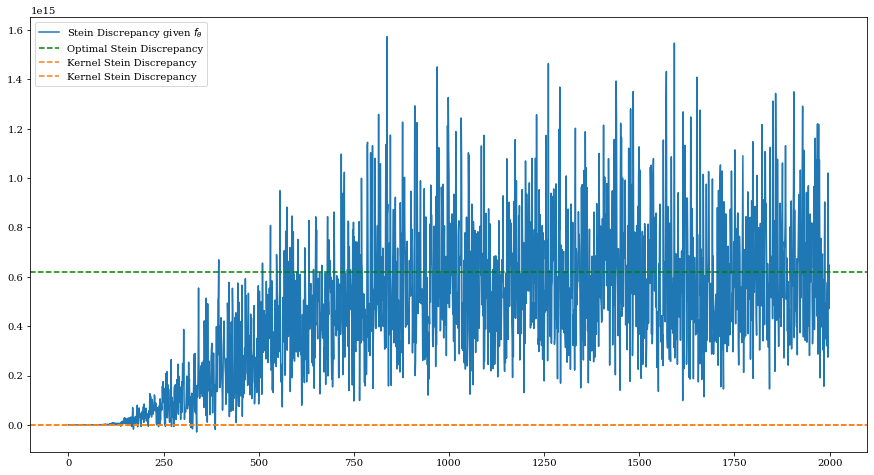

In [19]:
printsize = [5.4, 4]
showsize = [15, 8]
fig, axs = plt.subplots(figsize=showsize) # remember that latex textwidth is 5.4in

plt.plot(learner.rundata["training_sd"], label="Stein Discrepancy given $f_{\\theta}$")
plt.axhline(y=onp.mean(sds), linestyle="--", label="Optimal Stein Discrepancy", color="green")
plt.axhline(y=onp.mean(ksds), linestyle="--", label="Kernel Stein Discrepancy", color="tab:orange")
plt.axhline(y=onp.mean(median_heuristic_ksds), linestyle="--", label="Kernel Stein Discrepancy", color="tab:orange")
plt.legend()


# plt.savefig(figure_path + "sd_maxing.pgf")
# plt.savefig("sd_maxing.pgf")